# Lab 2: Grayscale Colorizer

# Exercise 1

## 1. Dataset and preprocessing
We use the CIFAR-10 dataset (60,000 colour images of size 32×32×3 in 10 classes).  
Pixels are normalised to the [0,1] range using `ToTensor()`.  
We merge the original train and test splits and randomly divide them into:
- 80% training
- 10% validation
- 10% test

This split is done with `random_split` from PyTorch.

In [37]:
import torch, torchvision
from torch.utils.data import random_split, DataLoader, ConcatDataset
from torchvision import datasets, transforms


transform = transforms.Compose([
    transforms.ToTensor(),                
])

all_data = ConcatDataset([
    datasets.CIFAR10(root="./data", train=True,  download=True, transform=transform),
    datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
])

n = len(all_data)

# Get sizes for train test and val
n_train = int(0.8 * n)
n_val   = int(0.1 * n)
n_test  = int(0.1 * n)

train_set, val_set, test_set = random_split(all_data, [n_train, n_val, n_test])

# DataLoaders, why do we shuffle only train?
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
val_loader   = DataLoader(val_set, batch_size=128, shuffle=False)
test_loader  = DataLoader(test_set, batch_size=128, shuffle=False)

len(train_loader), len(val_loader), len(test_loader)


Files already downloaded and verified
Files already downloaded and verified


(375, 47, 47)


## 2. Convolutional autoencoder architecture

The autoencoder compresses 32×32 RGB images into a low-dimensional latent representation and then reconstructs them.

**Encoder:**
- Conv2d: 3 → 8 channels, 3×3 kernel, padding=1, ReLU
- MaxPool2d: 2×2 (32×32 → 16×16)
- Conv2d: 8 → 12 channels, 3×3 kernel, padding=1, ReLU
- MaxPool2d: 2×2 (16×16 → 8×8)
- Conv2d: 12 → 16 channels, 3×3 kernel, padding=1, ReLU  

The latent space has shape 8×8×16 = 1024 values per image.

**Decoder:**
- Upsample: factor 2 (8×8 → 16×16)
- Conv2d: 16 → 12 channels, 3×3, ReLU
- Upsample: factor 2 (16×16 → 32×32)
- Conv2d: 12 → 3 channels, 3×3, Sigmoid

We train the model to minimise the mean squared error between the input and output images.


In [19]:
import torch.nn as nn

# ------------------------ MAIN MODEL DEFINITION ------------------------ #
class ConvolutionAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()

    
        #Auto encoder architecture
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = 3, stride=1, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride=2),
            nn.Conv2d(in_channels = 8, out_channels = 12, kernel_size = 3, stride=1, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(in_channels = 12, out_channels = 16, kernel_size = 3, stride=1, padding="same"),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="nearest"),
            nn.Conv2d(in_channels = 16, out_channels = 12, kernel_size = 3, stride=1, padding="same"),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode="nearest"),
            nn.Conv2d(in_channels = 12, out_channels = 3, kernel_size = 3, stride=1, padding="same"),
            nn.ReLU()
            
        )

    def forward(self, x):
        h = self.encoder(x)
        out = self.decoder(h)
        # tuple (reconstruction, latent)
        return out, h

# ------------------------ SHALLOWER MODEL DEFINITION ------------------------ #
class ShallowConvolutionAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 8, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        h = self.encoder(x)
        out = self.decoder(h)
        return out, h

# ------------------------ DEEPER MODEL DEFINITION ------------------------ #
class DeepConvolutionAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(16, 32, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(32, 64, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )

        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(64, 32, 3, stride=1, padding=1),
            nn.ReLU(),

            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(32, 16, 3, stride=1, padding=1),
            nn.ReLU(),

            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(16, 3, 3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        h = self.encoder(x)
        out = self.decoder(h)
        return out, h


# ------------------------ BIGGER FILTER MODEL DEFINITION ------------------------ #

class BiggerFilterConvolutionAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 8, 5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(8, 16, 5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(16, 8, 5, stride=1, padding=2),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(8, 3, 5, stride=1, padding=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        h = self.encoder(x)
        out = self.decoder(h)
        return out, h

# ------------------------ LARGER STRIDE MODEL DEFINITION ------------------------ #
class StridedConvolutionAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()

    
        #Auto encoder architecture
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = 3, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride=2),
            nn.Conv2d(in_channels = 8, out_channels = 12, kernel_size = 3, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(in_channels = 12, out_channels = 16, kernel_size = 3, stride=2, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="nearest"),
            nn.Conv2d(in_channels = 16, out_channels = 12, kernel_size = 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode="nearest"),
            nn.Conv2d(in_channels = 12, out_channels = 3, kernel_size = 3, stride=2, padding=1),
            nn.ReLU()
            
        )

    def forward(self, x):
        h = self.encoder(x)
        out = self.decoder(h)
        # tuple (reconstruction, latent)
        return out, h

## 3. Training procedure

We train with:
- Optimizer: Adam
- Learning rate: 1e-3
- Batch size: 128
- Number of epochs: 10

At each epoch we compute:
- **Training loss** on the training set
- **Validation loss** on the validation set

In [ ]:
import torch
import torch.optim as optim

# GPU acceleration for faster training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device being used: {device}")

def train_model(model, train_loader, val_loader, epochs=10, learning_rate=0.01, device=device):

    model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    validation_losses = []

    for e in range(epochs):
        model.train()
        current_loss = 0.0
        for batch_idx, (img, _) in enumerate(train_loader):
            
            img = img.to(device)
            # tuple returned from foward(x)
            reconstruction, latent = model(img)
            optimizer.zero_grad()

            # when the input equal to the target 
            loss = criterion(reconstruction, img)

            loss.backward()
            optimizer.step()

            current_loss += loss.item() * img.size(0)

        epoch_train_loss = current_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)


        model.eval()
        current_loss_val = 0.0

        with torch.no_grad():
            for img, _ in val_loader:
                img = img.to(device)
                reconstruction, latent = model(img)
                loss = criterion(reconstruction, img)
                current_loss_val += loss.item() * img.size(0)

        epoch_val_loss = current_loss_val / len(val_loader.dataset)
        validation_losses.append(epoch_val_loss)

        
        print(f"Epoch {e+1}/{epochs} "
            f"- Train loss: {epoch_train_loss:.4f}, Validation loss: {epoch_val_loss:.4f}")
        
    return model, train_losses, validation_losses



Device being used: cpu


In [21]:
baseModel = ConvolutionAutoEncoder()
trainedModel, train_losses, validation_losses = train_model(baseModel, train_loader, val_loader, epochs=10, learning_rate=0.001, device=device)

# Saving the trained model
torch.save(trainedModel.state_dict(), 'Base_conv_autoencoder.pth')


Epoch 1/10 - Train loss: 0.0292, Validation loss: 0.009605528756976127943700838330
Epoch 2/10 - Train loss: 0.0088, Validation loss: 0.008005475672582786084152672856
Epoch 3/10 - Train loss: 0.0077, Validation loss: 0.007111425124108791163968223970
Epoch 4/10 - Train loss: 0.0069, Validation loss: 0.006638724034031232186514603910
Epoch 5/10 - Train loss: 0.0065, Validation loss: 0.006264751541117827456084388160
Epoch 6/10 - Train loss: 0.0062, Validation loss: 0.005997933614999055584871001656
Epoch 7/10 - Train loss: 0.0060, Validation loss: 0.005815157110492388294054055820
Epoch 8/10 - Train loss: 0.0058, Validation loss: 0.005757048948357502624051384998
Epoch 9/10 - Train loss: 0.0056, Validation loss: 0.005529873116562764034931376500
Epoch 10/10 - Train loss: 0.0054, Validation loss: 0.005710303083062171630723824478


## 4. Results

### 4.1 Loss curves

Figure 1 shows the evolution of the training and validation MSE loss over epochs.  
The validation loss decreases and then stabilises after about 10 epochs, which indicates that the autoencoder has converged.

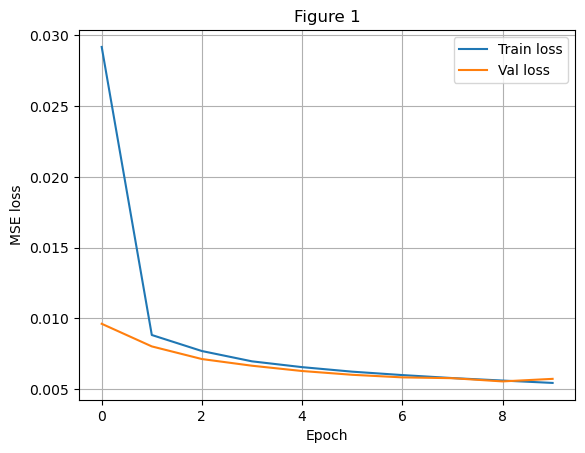

In [22]:
import matplotlib.pyplot as plt
def plot_losses(train_losses, validation_losses):
    plt.figure()
    plt.plot(train_losses, label="Train loss")
    plt.plot(validation_losses, label="Val loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE loss")
    plt.legend()
    plt.grid(True)
    plt.title("Figure 1")
    plt.show()

plot_losses(train_losses, validation_losses)

### 4.2 Test performance

After training, we evaluate the model on the test set.  

In [ ]:
def evaluate_model(model, data_loader, device=device):
    model.eval()
    criterion = nn.MSELoss()
    total_loss = 0.0
    total_samples = 0

    with torch.no_grad():
        for images, _ in data_loader:
            images = images.to(device)
            outputs, _ = model(images)
            loss = criterion(outputs, images)
            batch_size = images.size(0)
            total_loss += loss.item() * batch_size
            total_samples += batch_size

    return total_loss / total_samples

In [ ]:
test_loss = evaluate_model(trainedModel, test_loader)
print(f"Test Loss: {test_loss:.4f}")

Test Loss: 0.005708665053049723388245428879


### 4.3 Visual inspection

Figure 2 illustrates some original input images and their reconstructions.  
The reconstructions are slightly blurred but preserve the main objects and colours, which is expected for a simple convolutional autoencoder.


In [25]:
import torch
import matplotlib.pyplot as plt

def show_reconstruction(model, test_loader, device=device, num_images=5, title=""):
    model.eval()

    # 1. Take a single batch from the test (or val) loader
    img, _ = next(iter(test_loader)) 
    img = img.to(device)

    # 2. Get reconstructions
    with torch.no_grad():
        reconstruction, latent = model(img)         

    # 3. Move to CPU and (optionally) undo normalization
    orig = img.cpu()
    rec  = reconstruction.cpu()

    # 4. Plot first 7 originals and their reconstructions
    n_show = 7
    fig, ax = plt.subplots(2, n_show, figsize=(15, 4), dpi=250)

    for i in range(n_show):
        # [C, H, W] -> [H, W, C]
        img_np = orig[i].numpy().transpose((1, 2, 0))
        rec_np = rec[i].numpy().transpose((1, 2, 0))

        ax[0, i].imshow(img_np)
        ax[0, i].axis('off')

        ax[1, i].imshow(rec_np)
        ax[1, i].axis('off')
    ax[0, 0].set_title('Original')
    ax[1, 0].set_title('Reconstructed')
    plt.tight_layout()
    plt.show()

    # remember to add title to the graph 



Training model: Base
Epoch 1/1 - Train loss: 0.0319, Validation loss: 0.010653226161996523849162521458

Training model: Simple
Epoch 1/1 - Train loss: 0.0209, Validation loss: 0.006739920911689599621052781941

Training model: Deep
Epoch 1/1 - Train loss: 0.0204, Validation loss: 0.013909862739344438370414636097

Training model: WideKernel
Epoch 1/1 - Train loss: 0.0161, Validation loss: 0.010075776485105355020910344876

Training model: Strided


/Users/gustavokoglin/miniforge3/envs/cae-env/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([128, 3, 32, 32])) that is different to the input size (torch.Size([128, 3, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/gustavokoglin/miniforge3/envs/cae-env/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([112, 3, 32, 32])) that is different to the input size (torch.Size([112, 3, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/1 - Train loss: 0.0642, Validation loss: 0.047461868713299430744267937143


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.09361502..1.1961876].



 Model Performance Summary:
Base            | Test Loss: 0.005709
Simple          | Test Loss: 0.005709
Deep            | Test Loss: 0.005709
WideKernel      | Test Loss: 0.005709
Strided         | Test Loss: 0.005709


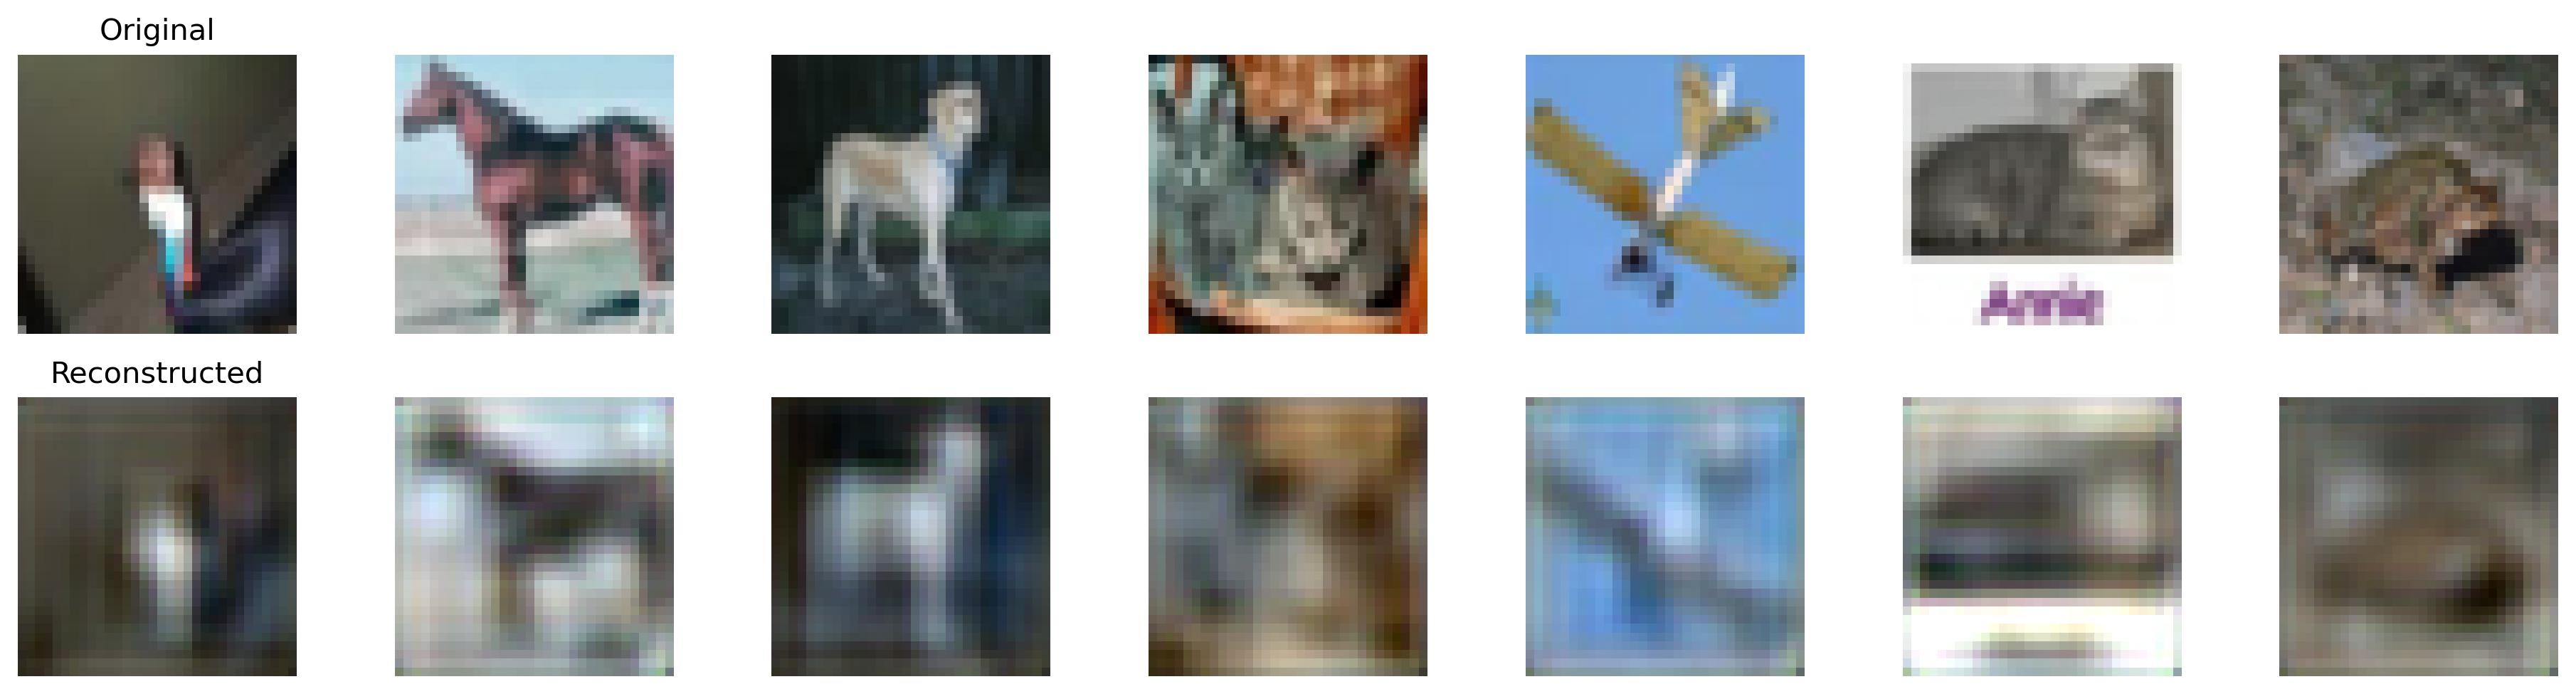

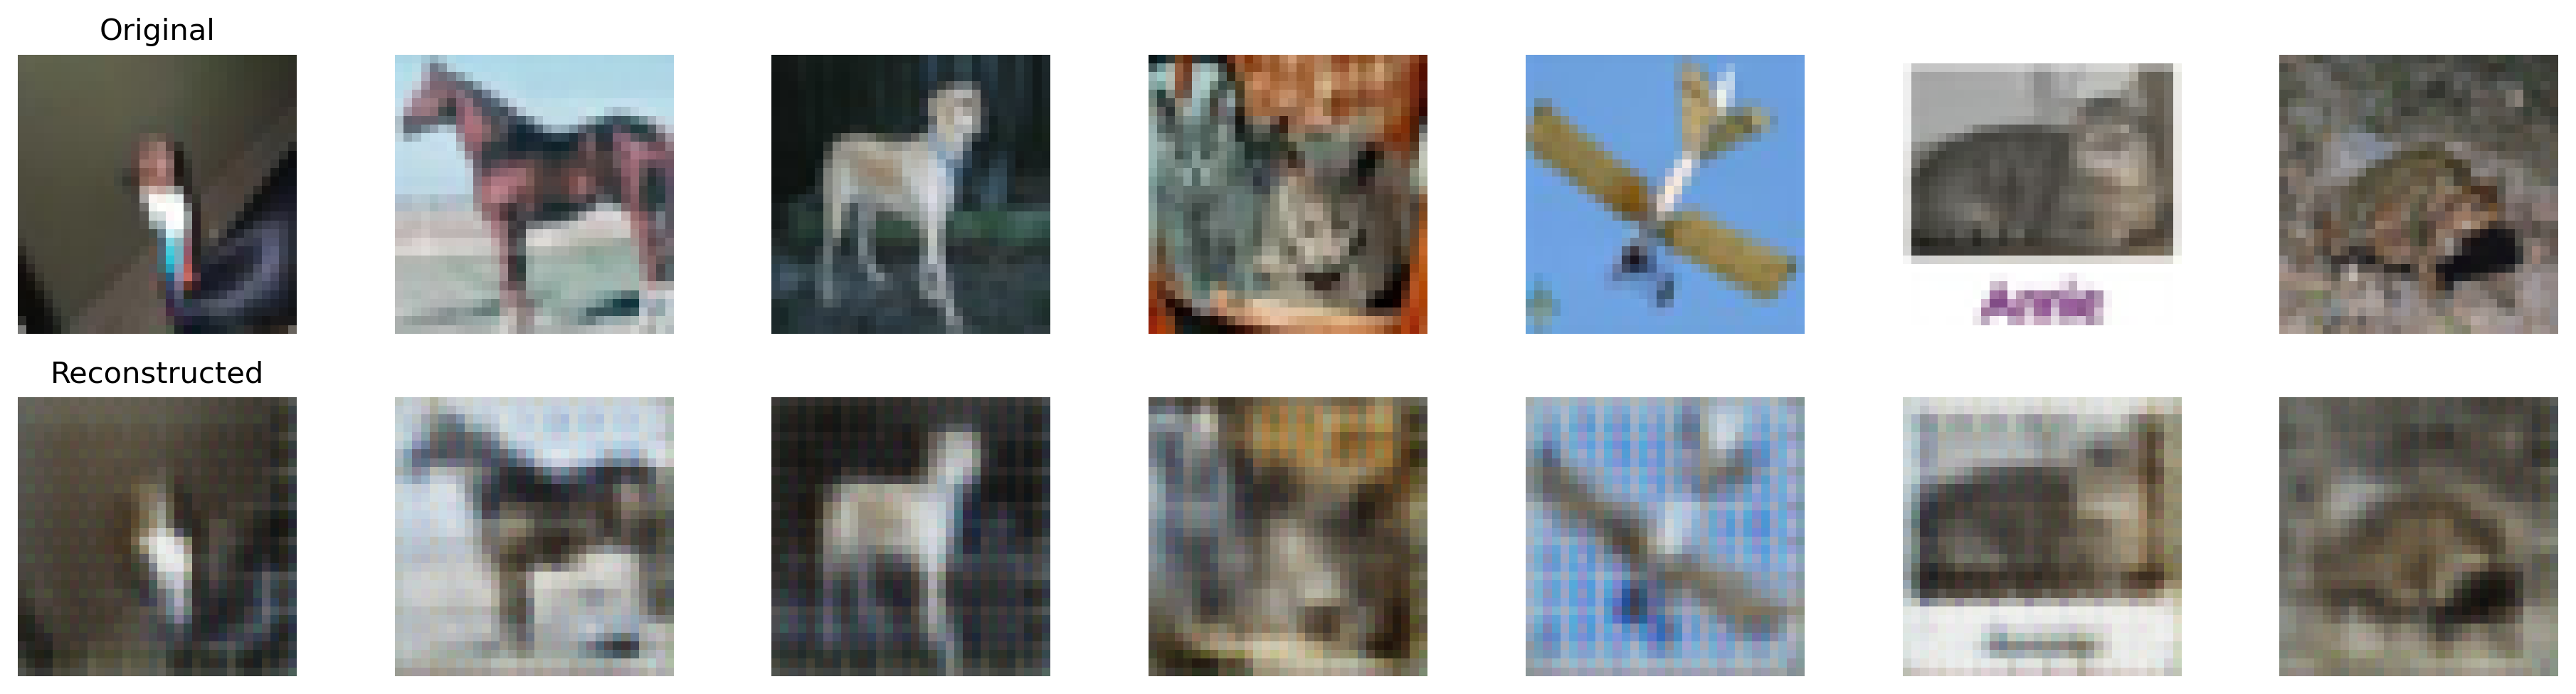

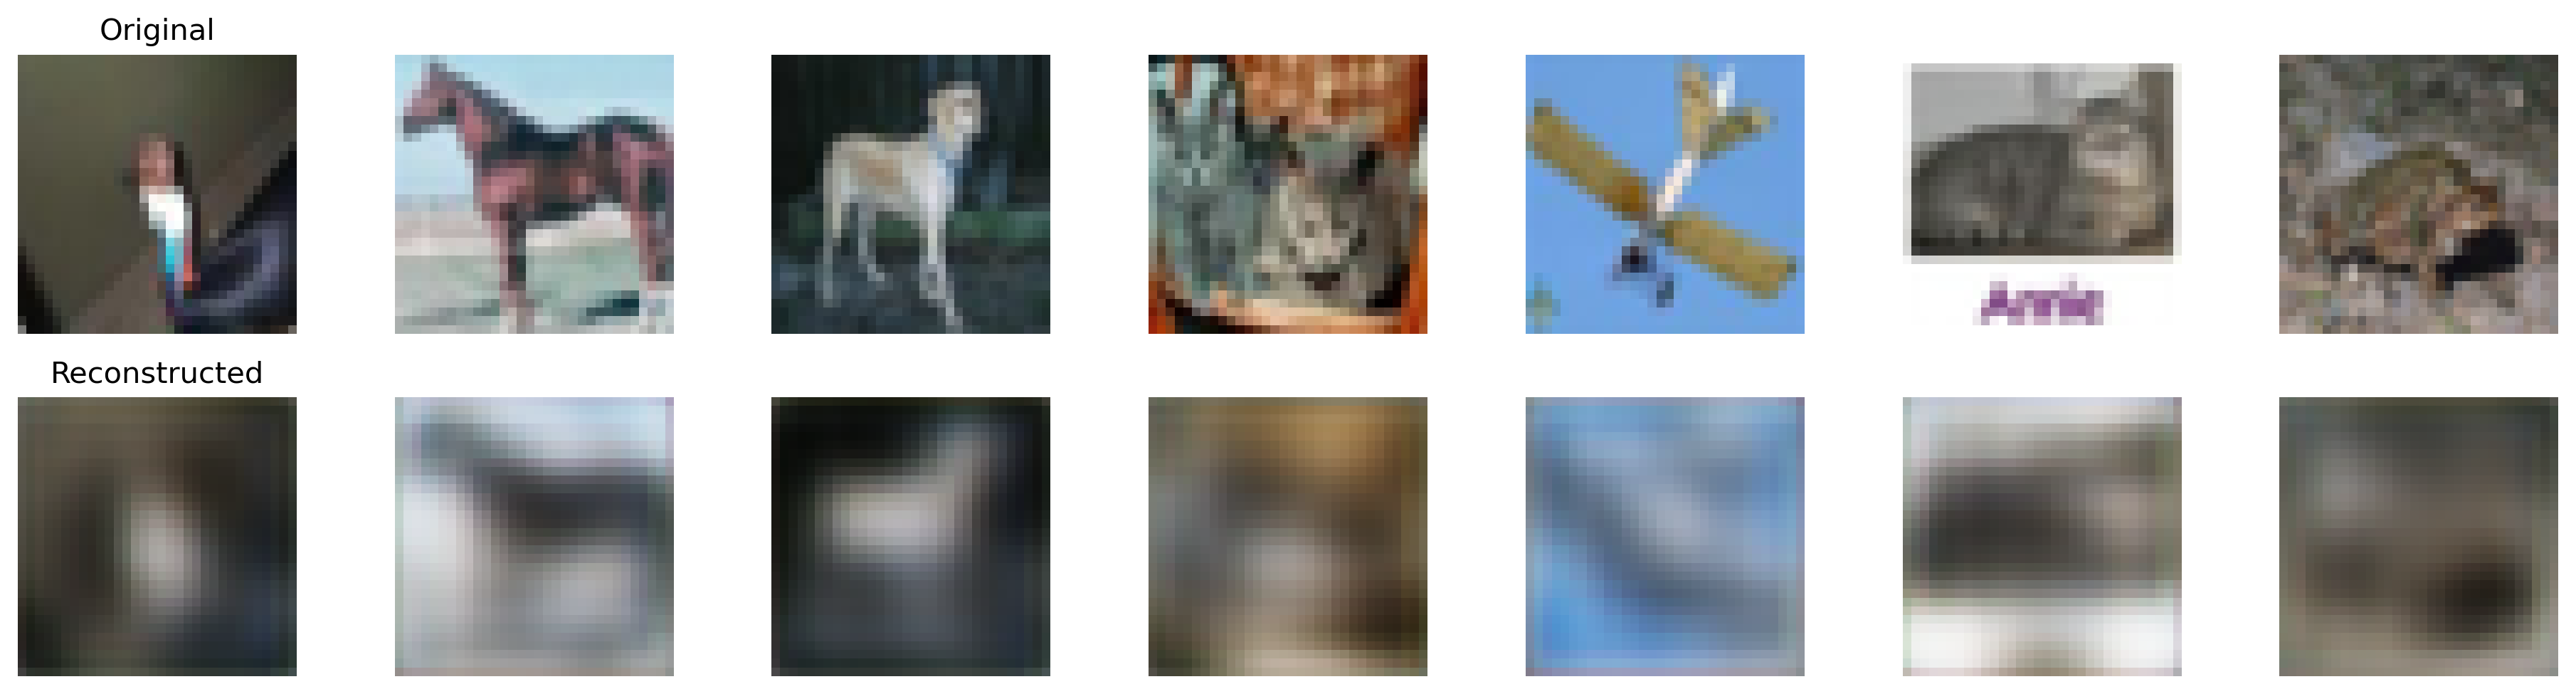

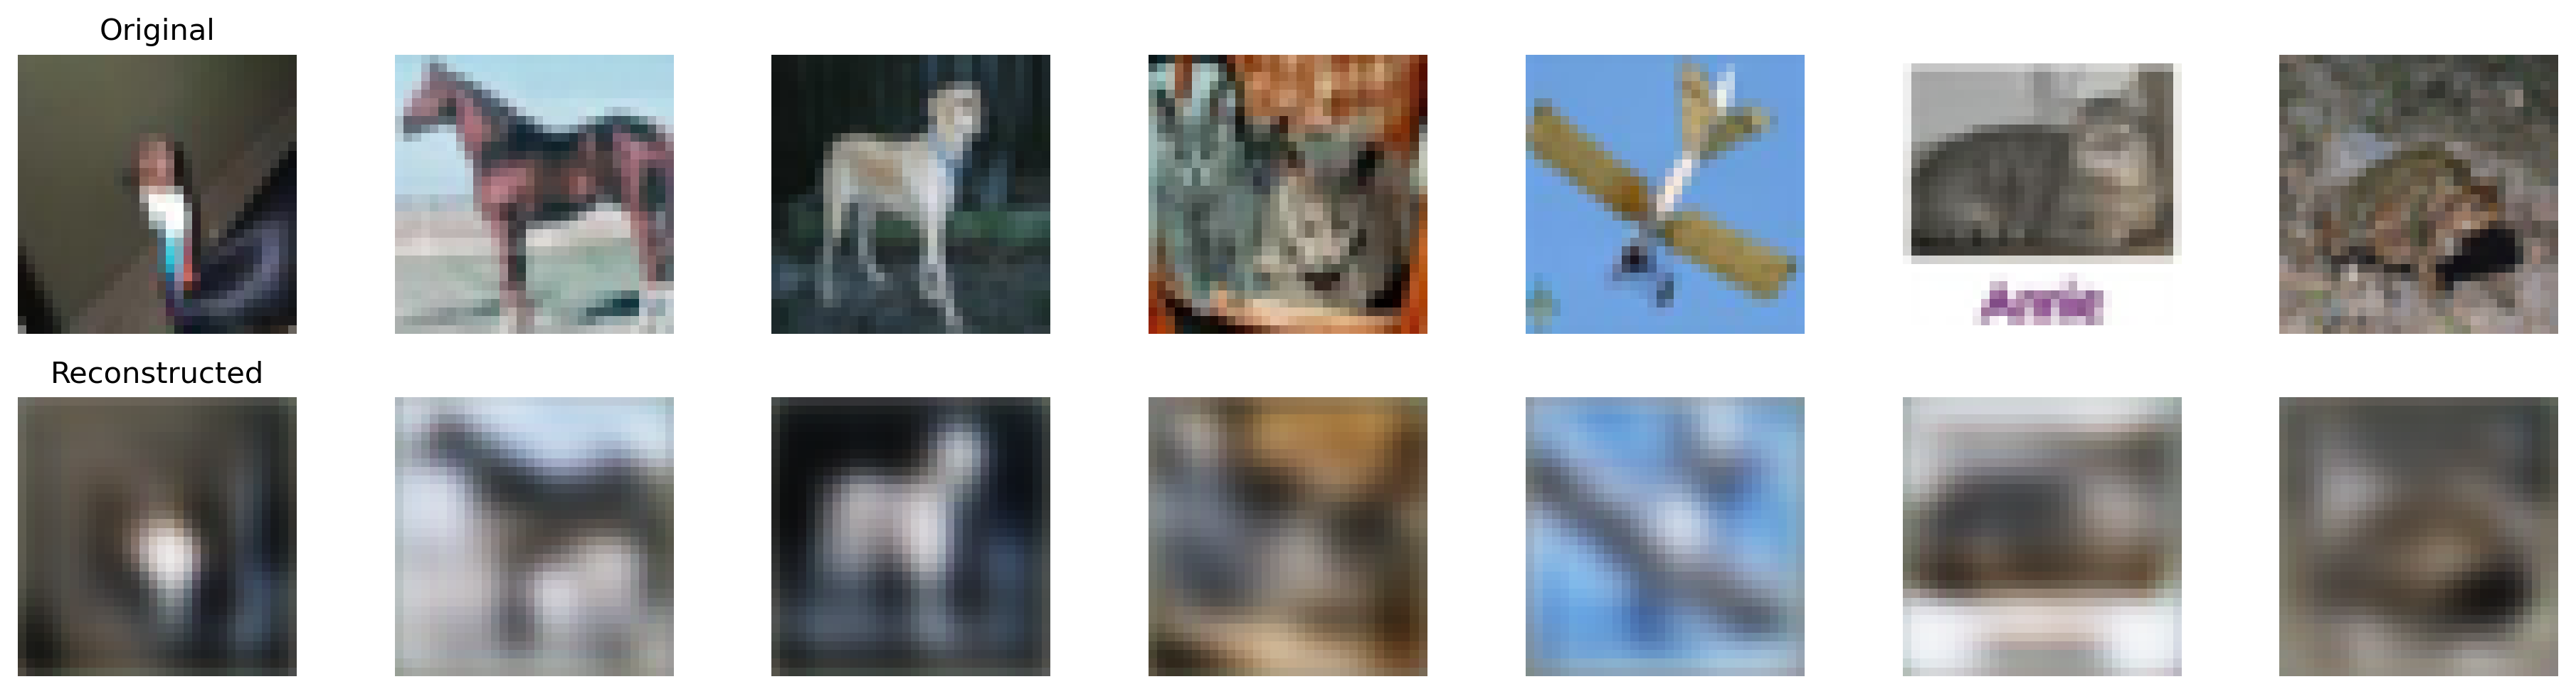

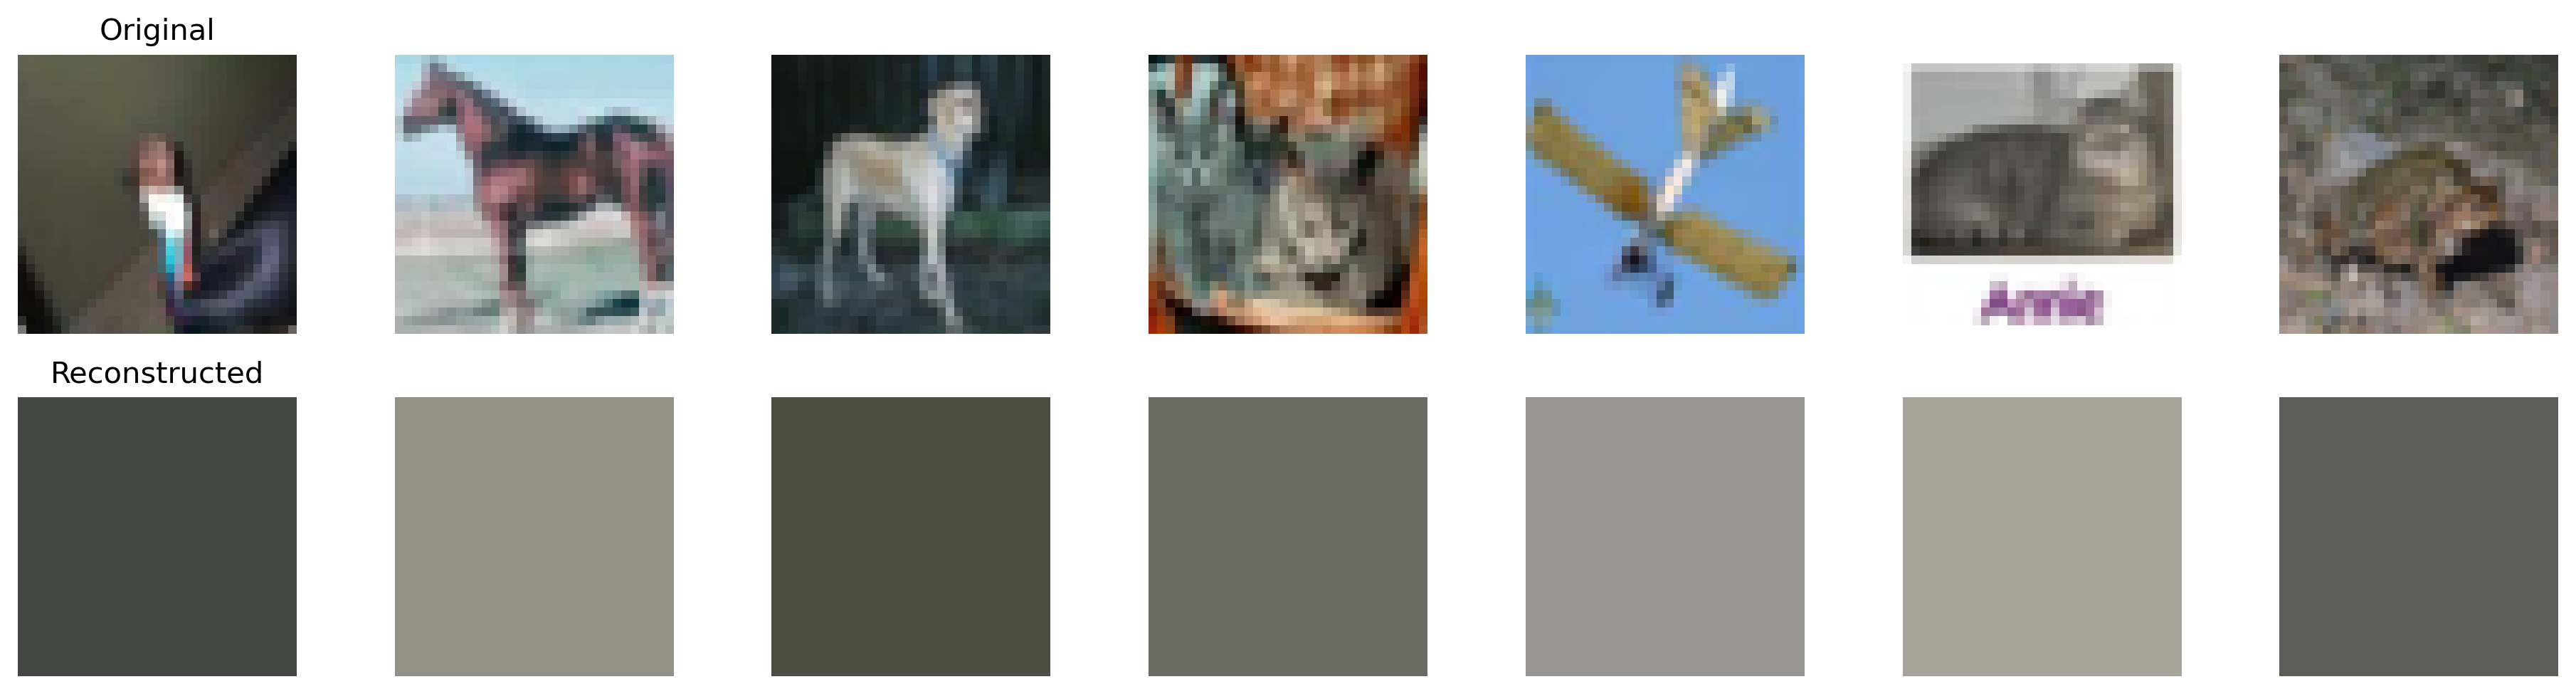

In [ ]:
models_to_test = {
    "Base": ConvolutionAutoEncoder(),
    "Simple": ShallowConvolutionAutoEncoder(),
    "Deep": DeepConvolutionAutoEncoder(),
    "WideKernel": BiggerFilterConvolutionAutoEncoder(),
    "Strided": StridedConvolutionAutoEncoder()
}

trained_models = {}

results = {}

for name, model in models_to_test.items():
    print(f"\n======================")
    print(f"Training model: {name}")
    print(f"======================")

    trained_model, train_losses, validation_losses = train_model(model, train_loader, val_loader, epochs=1, learning_rate=1e-3)
    
    # Saving the trained model
    torch.save(trained_model.state_dict(), f'{name.lower()}_conv_autoencoder.pth')

    test_loss = evaluate_model(trained_model, test_loader)

    results[name] = {
        "model": trained_model,
        "val_loss": validation_losses,
        "test_loss": test_loss
    }



# Show summary of results
print("\n Model Performance Summary:")
for name, entry in results.items():
    print(f"{name:<15} | Test Loss: {entry['test_loss']:.6f}")

# Optionally, show all the reconstructions
for name, entry in results.items():
    model = entry["model"]
    show_reconstruction(model, test_loader, device=device, title=f"Reconstruction - {name}")


# Exercise 3

In [32]:
# --- Cell: Dataset for colorization (gray -> RGB) ---
from torch.utils.data import Dataset, ConcatDataset, random_split, DataLoader
from torchvision import datasets, transforms

# Base CIFAR-10 without transforms (so we can build paired input/target)
base_train = datasets.CIFAR10(root="./data", train=True,  download=True, transform=None)
base_test  = datasets.CIFAR10(root="./data", train=False, download=True, transform=None)

class GrayToColorCIFAR(Dataset):
    """
    Returns:
      x: grayscale image replicated to 3 channels, shape [3, 32, 32], in [0,1]
      y: original RGB image, shape [3, 32, 32], in [0,1]
    """
    def __init__(self, baseds):
        self.baseds = baseds
        self.t_in  = transforms.Compose([
            transforms.Grayscale(num_output_channels=3),
            transforms.ToTensor()
        ])
        self.t_tgt = transforms.ToTensor()

    def __len__(self): 
        return len(self.baseds)

    def __getitem__(self, idx):
        img, _ = self.baseds[idx]     # PIL RGB
        x = self.t_in(img)            # [3,H,W] grayscale replicated to 3ch
        y = self.t_tgt(img)           # [3,H,W] RGB
        return x, y

# Merge original train+test and re-split 80/10/10
all_color = ConcatDataset([GrayToColorCIFAR(base_train), GrayToColorCIFAR(base_test)])
n = len(all_color)
n_train = int(0.8 * n)
n_val   = int(0.1 * n)
n_test  = n - n_train - n_val

train_set_c, val_set_c, test_set_c = random_split(all_color, [n_train, n_val, n_test])

# Reuse your previous batch size if you had one; otherwise 128 is fine
batch_size = 128
train_loader_c = DataLoader(train_set_c, batch_size=batch_size, shuffle=True,  num_workers=2)
val_loader_c   = DataLoader(val_set_c,   batch_size=batch_size, shuffle=False, num_workers=2)
test_loader_c  = DataLoader(test_set_c,  batch_size=batch_size, shuffle=False, num_workers=2)

len(train_set_c), len(val_set_c), len(test_set_c)


Files already downloaded and verified
Files already downloaded and verified


(48000, 6000, 6000)

In [ ]:
# --- Cell: Model + optimizer for colorization ---
import torch
import torch.optim as optim
import torch.nn as nn

model_c = ConvolutionAutoEncoder().to(device)   # reuse your class from earlier
criterion = nn.MSELoss()
optimizer_c = optim.Adam(model_c.parameters(), lr=0.01)  # 1e-3 is usually smoother than 1e-2
epochs_c = 5
